In [113]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.linalg import expm, logm

from edesign import *
from utility import *
from models import *
from edesign import *
from display import *

#setup autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Finding cliffords

In [114]:
# def X(qid):
#     return [('Gxpi2', qid)]

# def Z(qid):
#     return [('Gzpi2', qid)]

# def Y(qid):
#     return Z(qid) + X(qid) + Z(qid)*3


# def compile_clifford_1q_to_pygsti(cstring, qid):
#     chars_in_cstring = list(cstring)
#     circuit = []
#     for c in chars_in_cstring:
#         if c == 'I':
#             circuit += ([[]])
#         elif c == 'X':
#             circuit += (X(qid))
#         elif c == 'Y':
#             circuit += (Y(qid))
#         elif c == 'Z':
#             circuit += (Z(qid))
#         else:
#             raise ValueError('Invalid character in clifford string')
#     return circuit

def compile_pauli_string_1q_to_unitary(cstring):
    x = expm(-1j * np.pi/4 * SigX)
    y = expm(-1j * np.pi/4 * SigY)
    z = expm(-1j * np.pi/4 * SigZ)
    chars_in_cstring = list(cstring)
    unitary = np.eye(2)
    for c in chars_in_cstring:
        if c == 'I':
            pass
        elif c == 'X':
            unitary = x@unitary
        elif c == 'Y':
            unitary = y@unitary
        elif c == 'Z':
            unitary = z@unitary
        else:
            raise ValueError('Invalid character in clifford string')
    return unitary


In [115]:
from itertools import product

def product_upto(iterable, max_length):
  """
  Generate all possible combinations of elements from the given iterable,
  with the length of each combination less than or equal to max_length.

  Args:
    iterable: An iterable from which to generate combinations.
    max_length: The maximum length of the combinations.

  Returns:
    A list of tuples representing the combinations.
  """
  result = []
  for length in range(1, max_length + 1):
    for combination in product(iterable, repeat=length):
      result.append(combination)
  return result


In [116]:
def check_if_similar_clifford(u1, u2):
    # check if u1 and u2 are similar up to a global phase
    if np.allclose(u1, u2):
        return True
    elif np.allclose(u1, -u2):
        return True
    elif np.allclose(u1, 1j*u2):
        return True
    elif np.allclose(u1, -1j*u2):
        return True
    else:
        return False


In [117]:

def is_similar_in_list(string, list_of_strings):
    u = compile_pauli_string_1q_to_unitary(string)
    for s in list_of_strings:
        v = compile_pauli_string_1q_to_unitary(s)
        if check_if_similar_clifford(u, v):
            return True
    return False


def find_clifford_group_representation():
    all_strings = [('I', )] + product_upto('XYZ', 6)

    # now find a the unique strings until you have 24
    unique_strings = []
    for s in all_strings:
        if not is_similar_in_list(s, unique_strings):
            unique_strings.append(s)
        if len(unique_strings) == 24:
            break
    # convert the strings to a list of strings
    unique_strings = [''.join(s) for s in unique_strings]
    return unique_strings

    

In [118]:
clifford_group = find_clifford_group_representation()
clifford_group

['I',
 'X',
 'Y',
 'Z',
 'XX',
 'XY',
 'XZ',
 'YY',
 'YZ',
 'ZX',
 'ZZ',
 'XXX',
 'XXY',
 'XXZ',
 'XYY',
 'XZX',
 'XZZ',
 'YYY',
 'YYZ',
 'ZZZ',
 'XXXZ',
 'XXZX',
 'XYYZ',
 'XZZZ']

# Calculating cartan phases and frames (derivatives)

In [181]:
def compile_clifford_folded_cz_unitary(cz_unitary, k1_before, k2_before, k1_after, k2_after):
    # k1_before, k2_before, k1_after, k2_after are the clifford strings before and after the CZ gate
    # returns the circuit for the CZ gate
    u1 = compile_pauli_string_1q_to_unitary(k1_before)
    u2 = compile_pauli_string_1q_to_unitary(k2_before)
    U_before = np.kron(u1, u2)
    u1_after = compile_pauli_string_1q_to_unitary(k1_after)
    u2_after = compile_pauli_string_1q_to_unitary(k2_after)
    U_after = np.kron(u1_after, u2_after)
    return U_after @ cz_unitary @ U_before

In [182]:
x = 0.01*np.random.randn(15)
model = UnitaryGateSetModel_CZOnly()
cz_noisy = model.gate('CZ', x)
cz_target = model.gate('CZ', np.zeros(15))

In [183]:
U_folded = compile_clifford_folded_cz_unitary(cz_noisy, 'X', 'X', 'I', 'I')



# def calc_cartan_coefs(U, basis=cartan_basis):
#     cartan_coefs = np.array([ np.trace(U @ B) for B in basis])
#     return cartan_coefs

# def calc_cartan_frame(U, basis=cartan_basis):
#     # calculate the cartan frame of the unitary U
#     # basis is the cartan basis
#     # returns the cartan frame
#     log_U = logm(U)
#     cartan_frame = np.array([ np.trace(log_U @ B) for B in basis])
#     # check that the frame is imaginary
#     assert np.allclose(np.real(cartan_frame), 0)
#     return np.imag(cartan_frame)


# something the AI came up with:
    # U = U/np.linalg.det(U)**(1/4)
    # U = U/np.linalg.norm(U)
    # U = np.linalg.inv(U)
    # cartan_frame = []
    # for B in basis:
    #     cartan_frame.append(np.trace(U @ B))
    # return cartan_frame

In [193]:
cartan_basis = [
    np.diag([1, -1, 0, 0]),
    np.diag([0, 1, -1, 0]), 
    np.diag([0, 0, 1, -1]),
]

def calc_cartan_phases(U, basis=cartan_basis):
    log_U = logm(U)
    cartan_phases = np.array([ np.trace(log_U @ B) for B in basis])
    # check that the frame is imaginary
    assert np.allclose(np.real(cartan_phases), 0)
    return np.imag(cartan_phases)

def calc_cartan_jacobian(U, model, epsilon=1e-6):
    basis = model.cartan_basis
    num_params = model.num_params
    jacobian = np.zeros((len(basis), num_params))
    for i in range(num_params):
        X_i = model.lie_basis(i)
        U_plus = expm(1j*epsilon*X_i) @ U
        U_minus = expm(-1j*epsilon*X_i) @ U
        phases_plus = calc_cartan_phases(U_plus, basis)
        phases_minus = calc_cartan_phases(U_minus, basis)
        jacobian[:, i] = angular_difference(phases_plus, phases_minus)/(2*epsilon)
    return jacobian

In [194]:
angular_difference

<function utility.angular_difference(phi1, phi2)>

In [195]:
print(calc_cartan_phases(cz_noisy), calc_cartan_phases(cz_target))

[ 0.00660299 -0.01587074  3.14434124] [ 0.          0.         -3.14159265]


In [196]:
calc_cartan_jacobian(U_folded, model)

array([[ 1.91959191e-01,  8.64805742e-01, -1.54096306e+00,
        -8.72008854e-01, -1.07079149e+00,  1.78966976e-01,
         1.21120999e+00,  8.47064954e-01, -8.78090696e-01,
         1.62009257e-01,  3.50609704e-01, -3.24769771e-01,
         1.76079400e-01,  1.53382788e+00, -1.08332980e+00],
       [-1.04956408e+00, -1.76711379e-03,  1.21956661e+00,
         1.04839487e+00, -6.72906930e-03, -1.04726042e+00,
        -1.04558535e+00,  2.42844476e-02,  1.04793952e+00,
        -5.57762725e-03,  1.18805430e+00, -1.21443693e+00,
         1.03468443e+00, -1.20002741e+00, -3.37331607e-03],
       [ 1.55153284e+00, -7.33053611e-01, -7.48282284e-01,
         5.28055551e-01,  2.33408817e-01,  1.54286372e+00,
        -1.57480723e+00, -7.26933039e-01,  5.16268949e-01,
         1.48366224e+00, -4.98174077e-01,  4.74657639e-01,
        -2.60299231e+00,  7.27421528e-01,  2.90649021e-01]])

In [197]:
calc_cartan_jacobian(cz_target, model)

array([[ 0.,  0., -2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., -2.],
       [ 0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -2.,  0.,
         0.,  0.],
       [ 0.,  0., -2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  2.]])

In [198]:
calc_cartan_jacobian(cz_noisy, model)

array([[-1.87054554e-02, -8.64919492e-03, -1.99987411e+00,
        -9.19775678e-03, -1.49547883e-02, -8.95704044e-03,
        -8.74467454e-03,  3.68434572e-03, -7.81269494e-03,
         2.97980551e-03, -2.81163270e-03,  5.55462343e-05,
        -1.86970424e-02, -8.54527960e-03, -1.99989910e+00],
       [ 1.65277516e-02,  4.73661443e-03,  1.99992593e+00,
        -8.84042128e-03,  1.18572556e-02,  1.10039355e-03,
        -9.25756072e-03, -2.88000623e-03, -1.11629883e-03,
         1.19278378e-02,  3.67986708e-03, -1.99994589e+00,
         2.12725215e-03,  3.84907417e-03,  3.72701869e-06],
       [-1.44009322e-02, -9.22579346e-04, -1.99991459e+00,
         9.17746856e-03, -1.48786057e-02, -8.89775253e-03,
         8.92148577e-03, -3.73913123e-03, -7.78292275e-03,
         3.01379921e-03,  2.95808333e-03,  7.61235519e-06,
         1.44519772e-02,  9.06213771e-04,  1.99993957e+00]])

In [199]:
def calculate_frame_derivative(U, model):
    # calculate the derivative of the cartan frame with respect to the parameters
    # param0 is the parameters of the unitary
    basis = model.cartan_basis
    num_params = model.num_params
    jacobian = np.zeros((len(basis), num_params), dtype=complex)
    log_U = logm(U)
    for i in range(num_params):
        dU = model.lie_basis(i)
        for j, B in enumerate(basis):
            jacobian[j, i] = np.trace(log_U @ dU @ B)
    assert np.allclose(np.real(jacobian), 0, atol=1e-5), print(np.max(np.real(jacobian)))   
    return np.imag(jacobian)

In [203]:
from tqdm import tqdm

In [211]:
def make_all_cz_clifford_pairs():
    all_cliffords = find_clifford_group_representation()
    all_clifford_folds = []
    for k1 in all_cliffords:
        for k2 in all_cliffords:
            U_folded = compile_clifford_folded_cz_unitary(cz_noisy, k1, k2, 'I', 'I')
            all_clifford_folds.append((k1, k2, U_folded))
    return all_clifford_folds

In [212]:
clifford_cz_pairs = make_all_cz_clifford_pairs()

In [215]:
all_frames = {}
for k1, k2, U_folded in tqdm(clifford_cz_pairs):
    frame = calc_cartan_jacobian(U_folded, model)
    all_frames[(k1, k2)] = frame

100%|██████████| 576/576 [00:28<00:00, 20.09it/s]


In [226]:
def calc_frame_potential(frame):
    fpot = 0
    for row1 in frame:
        for row2 in frame:
            fpot += np.abs(np.dot(row1.conj().T, row2))**2
    return fpot

def stack_frame_dict(frame_dict):
    frames = []
    for k, frame in frame_dict.items():
        frames.append(frame)
    return np.vstack(frames)

def find_optimal_frame_set(starting_frame_dict, all_frames, max_frames=5):
    # starting_frame is the initial frame
    # all_frames is a dictionary of all the frames of the folded CZ gates
    # max_frames is the maximum number of frames to use
    # returns the optimal set of frames
    optimal_frame_dict = starting_frame_dict.copy()
    for i in tqdm(range(max_frames-len(starting_frame_dict))):
        min_potential = np.inf
        best_frame = None
        best_frame_key = None
        old_frames = stack_frame_dict(optimal_frame_dict)
        for k, frame in all_frames.items():
            if k in optimal_frame_dict:
                continue
            new_frames = np.vstack([old_frames, frame])
            potential_with_new_frame = calc_frame_potential(new_frames)
            if potential_with_new_frame < min_potential:
                min_potential = potential_with_new_frame
                best_frame = frame
                best_frame_key = k
        if best_frame is not None:
            optimal_frame_dict[best_frame_key] = best_frame
    return optimal_frame_dict


In [227]:
len(all_frames)

576

In [228]:
starting_interleaving_pair = ('XX', 'Y')
starting_frame_dict = {}
starting_frame_dict[starting_interleaving_pair] = all_frames[starting_interleaving_pair]
optimal_frame_dict = find_optimal_frame_set(starting_frame_dict, all_frames)

100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


In [231]:
optimal_frame_dict

{('XX',
  'Y'): array([[ 9.56496298e-01,  7.06827894e-02, -1.00746476e+00,
          1.12603238e+00,  1.08896080e+00, -1.08245254e+00,
         -1.13638127e+00,  1.14963864e+00, -1.08845708e+00,
          1.08190692e+00,  1.12009926e+00,  3.31413252e-03,
         -1.03614371e+00,  2.13797779e-03, -9.97687347e-01],
        [-4.78435924e-01, -4.91355427e-02,  5.09787425e-01,
         -1.65883042e+00, -2.76104465e+00, -5.97382291e-01,
          5.75518846e-01,  5.19674903e-01,  5.47524071e-01,
         -1.66666388e+00,  1.66280710e+00, -2.34503927e-03,
          5.41405942e-01, -1.55668720e+00,  5.00991467e-01],
        [ 2.77443177e-02, -7.42188955e-03, -2.03950745e-02,
         -1.44152179e-02,  2.23644856e+00,  1.56292468e-02,
          2.20280341e+00, -3.34414885e-02, -2.21049031e+00,
          4.80345652e-03, -2.18744172e+00, -1.15991170e-02,
         -2.70908069e-02,  3.12304116e+00,  1.06176627e-02]]),
 ('ZZZ',
  'Z'): array([[ 3.04331529e-02, -1.16384451e-01, -1.99848143e+00,
    

In [232]:
optimal_frame_dict.keys()

dict_keys([('XX', 'Y'), ('ZZZ', 'Z'), ('XYYZ', 'I'), ('XXXZ', 'XXXZ'), ('ZZ', 'XZ')])

In [239]:
total_jacobian = stack_frame_dict(optimal_frame_dict)
np.linalg.matrix_rank(total_jacobian)

15

# check the stability of the identified experiment

In [235]:
optimal_germs = [
    ['X1', 'X1', 'Y2', 'CZ'],
    ['Z1', 'Z1', 'Z1', 'Z2', 'CZ'],
    ['X1', 'Y1', 'Y1', 'Z1', 'CZ'],
    ['X1', 'X1', 'X1', 'Z1', 'X2', 'X2', 'X2', 'Z2', 'CZ'],
    ['Z1', 'Z1', 'X2', 'Z2', 'CZ'],
]
depths = [i+1 for i in range(1000)]

edesign = RPEDesign(UnitaryGateSetModel_CZOnly(), optimal_germs, depths)

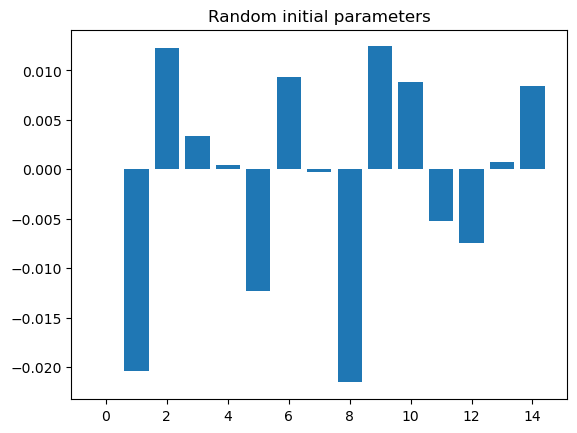

<Figure size 640x480 with 0 Axes>

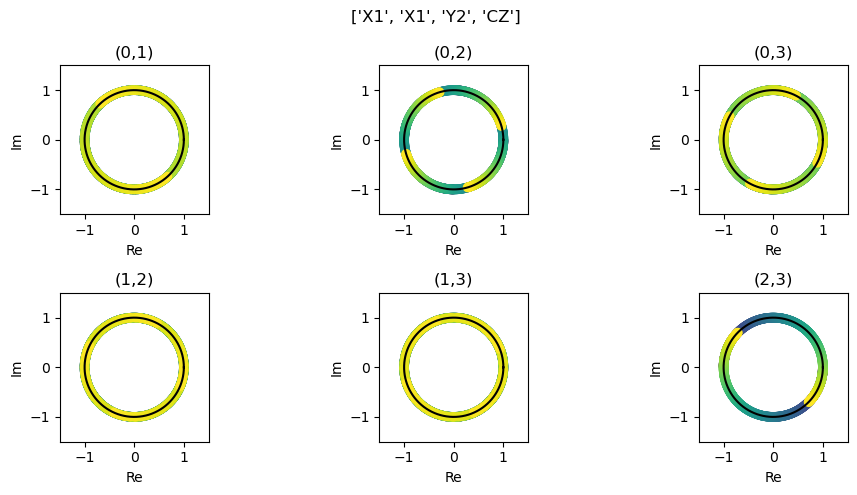

<Figure size 640x480 with 0 Axes>

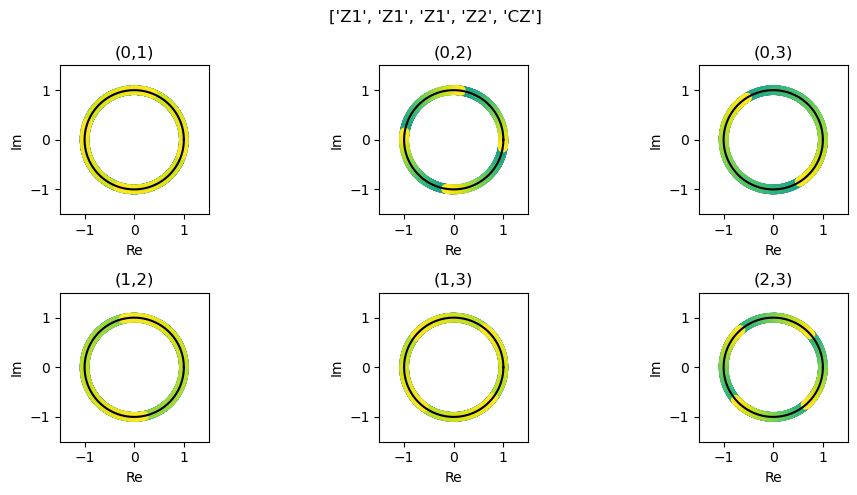

<Figure size 640x480 with 0 Axes>

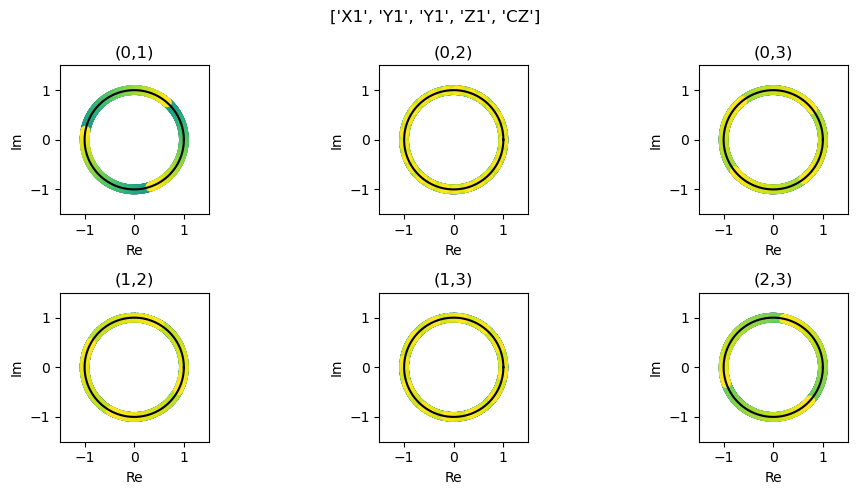

<Figure size 640x480 with 0 Axes>

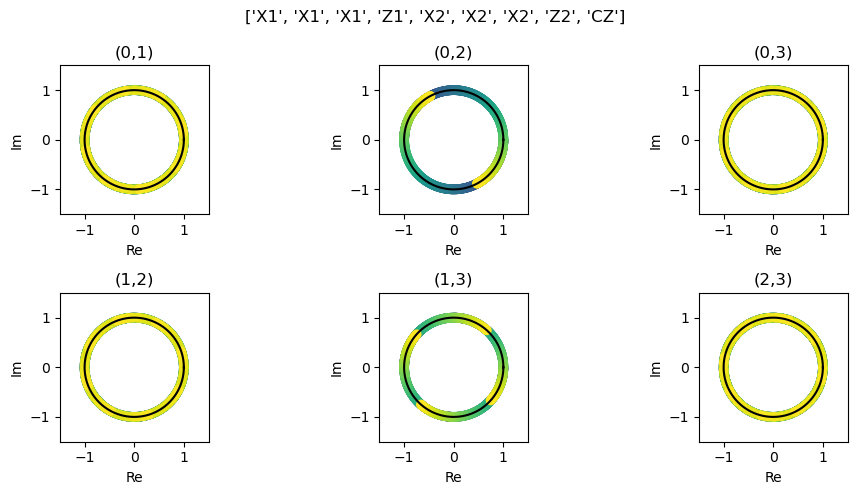

<Figure size 640x480 with 0 Axes>

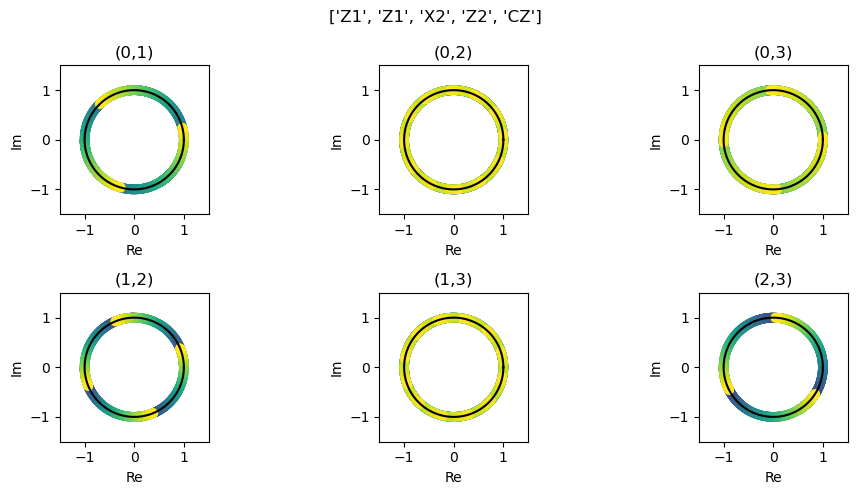

<Figure size 640x480 with 0 Axes>

In [237]:
x = 0.01*np.random.randn(15)
plt.bar(range(15), x)
plt.title('Random initial parameters')
plt.show()
plt.figure()
for germ in optimal_germs:
    plot_cartan_signals(edesign, germ, x)
    plt.show()
    plt.figure()